In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [237]:
df = pd.read_csv("credit_card_fraud_dataset.csv")

In [238]:
df.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,15:35.5,4189.27,688,travel,San Antonio,1
1,2,20:35.5,2659.71,109,travel,Chicago,1
2,3,08:35.5,784.00,394,online,Los Angeles,1
3,4,50:35.5,3514.40,944,online,Phoenix,1
4,5,51:35.5,369.07,475,online,Phoenix,1


In [239]:
df.shape

(100000, 7)

In [240]:
df.isnull().sum()

,0
TransactionID,0
TransactionDate,0
Amount,0
MerchantID,0
TransactionType,0
Location,0
IsFraud,0


In [241]:
df.describe()

,TransactionID,Amount,MerchantID,IsFraud
count,100000.000000,100000.000000,100000.000000,100000.00000
mean,50000.500000,2497.092666,501.676070,0.11061
std,28867.657797,1442.415999,288.715868,0.31365
min,1.000000,1.050000,1.000000,0.00000
25%,25000.750000,1247.955000,252.000000,0.00000
50%,50000.500000,2496.500000,503.000000,0.00000
75%,75000.250000,3743.592500,753.000000,0.00000
max,100000.000000,4999.770000,1000.000000,1.00000


In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


In [243]:
# Check the target 'fraud'
print('Non-fraud:', round(df['IsFraud'].value_counts()[0]/len(df)*100, 2), '% of the transactions')
print('Fraud:', round(df['IsFraud'].value_counts()[1]/len(df)*100, 2), '% of the transactions')

Non-fraud: 88.94 % of the transactions
Fraud: 11.06 % of the transactions


Data is imbalaced

In [244]:
#Checking missing data
df.isnull().sum()

,0
TransactionID,0
TransactionDate,0
Amount,0
MerchantID,0
TransactionType,0
Location,0
IsFraud,0


In [245]:
df.nunique()

,0
TransactionID,100000
TransactionDate,360
Amount,90621
MerchantID,1000
TransactionType,4
Location,10
IsFraud,2


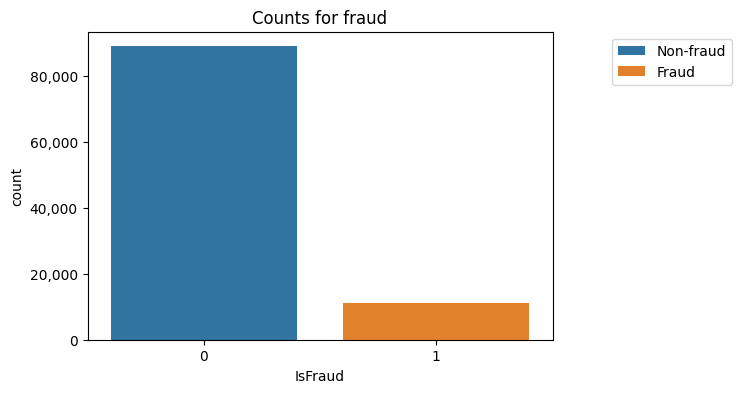

In [246]:
import matplotlib as mpl
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.countplot(x='IsFraud', data=df, hue='IsFraud', dodge=False)
plt.title('Counts for fraud')
plt.legend(labels = ['Non-fraud','Fraud'], bbox_to_anchor=(1.4, 1))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

<Axes: >

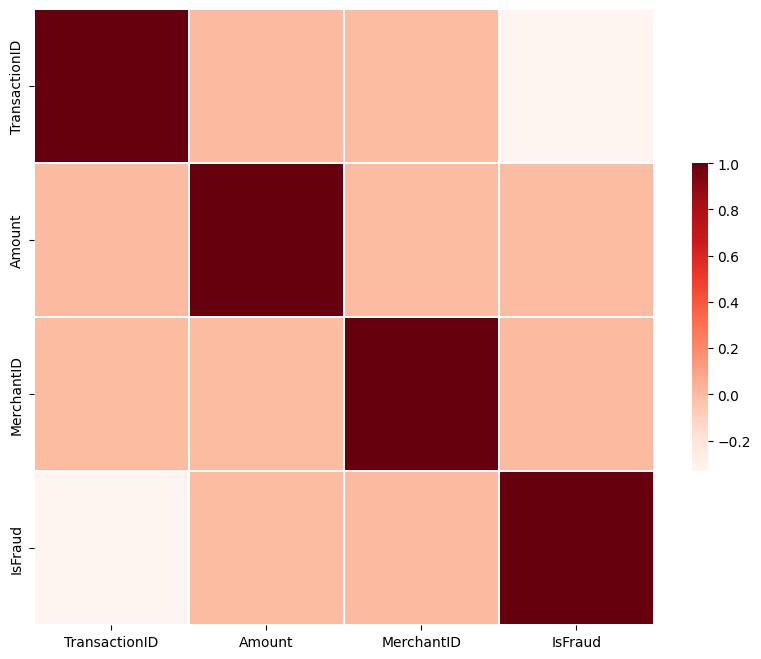

In [247]:
fig = plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(data=corr, cmap='Reds', linewidth=0.1, cbar_kws={"shrink": 0.5})

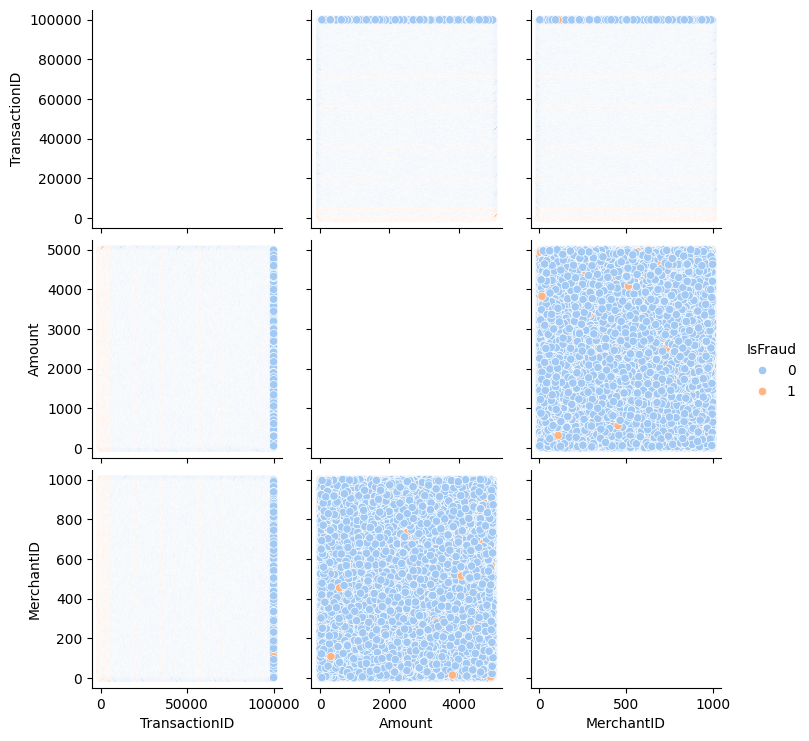

In [248]:
sns.pairplot(data=df, hue='IsFraud', palette= 'pastel', diag_kind='scatter')

In [249]:
#Fraud Distribution by Fraud Type
import plotly.express as px
fraud_df = df[df['IsFraud'] == 1]
fig = px.bar(
    x=fraud_df['TransactionType'].value_counts().index,
    y=fraud_df['TransactionType'].value_counts().values,
    title="Fraud by Transaction Type",
    labels={'x': 'TransactionType', 'y': 'IsFraud Count'},
    color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

#Fraud Distribution by Fraud Type - Location
import plotly.express as px
fig = px.bar(
    x=fraud_df['Location'].value_counts().index,
    y=fraud_df['Location'].value_counts().values,
    title="Fraud by Location",
    labels={'x': 'Location', 'y': 'Fraud Count'},
    color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

#Fraud Distribution by Fraud Type - Amount
import plotly.express as px
fig = px.histogram(fraud_df, x='Amount', nbins=20, title='Fraud by Amount',
                   labels={'Amount', 'Fraud Count'},
    color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


In [251]:
df.groupby('TransactionType')['TransactionType'].agg('count')

,TransactionType
TransactionType,
CardPresent,28291
online,45318
refund,20146
travel,6245


In [252]:
df['TransactionType'] = df['TransactionType'].apply({'CardPresent':1, 'online':2, 'refund':3, 'travel':4 }.get)

In [253]:
df.isnull().sum()

,0
TransactionID,0
TransactionDate,0
Amount,0
MerchantID,0
TransactionType,0
Location,0
IsFraud,0


In [254]:
df.groupby('Location')['Location'].agg('count')

,Location
Location,
Chicago,14485
Dallas,5784
Houston,11109
Los Angeles,10146
New York,8665
Philadelphia,8736
Phoenix,11097
San Antonio,12923
San Diego,8447


In [255]:
df['Location'] =df['Location'].apply({'Chicago': 1, 'Dallas':2, 'Houston':3, 'Los Angeles':4, 'New York':5, 'Philadelphia':6, 'Phoenix':7, 'San Antonio':8, 'San Diego':9, 'San Jose':10 }.get)

In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  int64  
 5   Location         100000 non-null  int64  
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 5.3+ MB


In [257]:
numeric_c= df.select_dtypes(include=['int64','float64'])
numeric_c.corr()

,TransactionID,Amount,MerchantID,TransactionType,Location,IsFraud
TransactionID,1.000000,0.001972,-0.003623,-0.222430,0.043877,-0.333118
Amount,0.001972,1.000000,-0.000386,0.000344,-0.000069,0.000058
MerchantID,-0.003623,-0.000386,1.000000,0.001669,-0.002424,0.002734
TransactionType,-0.222430,0.000344,0.001669,1.000000,-0.026108,0.204970
Location,0.043877,-0.000069,-0.002424,-0.026108,1.000000,-0.028456
IsFraud,-0.333118,0.000058,0.002734,0.204970,-0.028456,1.000000


In [258]:
df = numeric_c

In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   Amount           100000 non-null  float64
 2   MerchantID       100000 non-null  int64  
 3   TransactionType  100000 non-null  int64  
 4   Location         100000 non-null  int64  
 5   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 4.6 MB


In [260]:
#Train Test Split without under or Over sampling
# Define the predictors and target
X = df.drop('IsFraud', axis=1)
Y = df['IsFraud']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state = 91)
X.shape, Y.shape, X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((100000, 5), (100000,), (70000, 5), (30000, 5), (70000,), (30000,))

In [261]:
model = LogisticRegression()
model.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [262]:
predictions = model.predict(X_test)

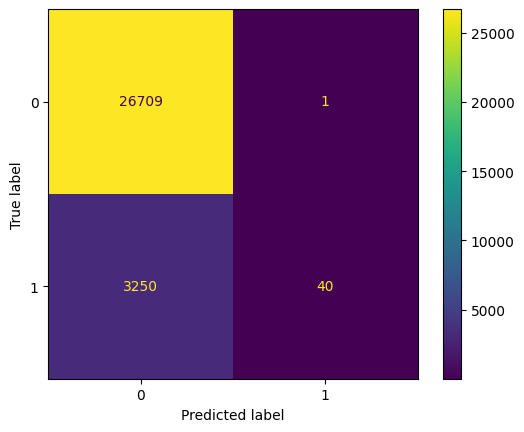

In [263]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
cm = ConfusionMatrixDisplay(confusion_matrix(Y_test, predictions)).plot()

In [264]:
report = classification_report(Y_test, predictions)
print("Classification Report")
print(report)
acc = accuracy_score(Y_test, predictions)
prec = precision_score(Y_test, predictions)
rec = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)
print('accuracy:%0.4f'%acc,'\tprecision:%0.4f'%prec,'\trecall:%0.4f'%rec,'\tF1-score:%0.4f'%f1)


Classification Report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     26710
           1       0.98      0.01      0.02      3290

    accuracy                           0.89     30000
   macro avg       0.93      0.51      0.48     30000
weighted avg       0.90      0.89      0.84     30000

accuracy:0.8916 	precision:0.9756 	recall:0.0122 	F1-score:0.0240


RandomForest

In [293]:
X = df.drop('IsFraud', axis=1)
Y = df['IsFraud']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=y, random_state=42)

print('No. of Transactions in Training Set: {:,}'.format(len(X_train)))
print('No. of Transactions in Test Set: {:,}'.format(len(X_test)))
print('Total No. of Transactions: {:,}'.format(len(X_train) + len(X_test)))

No. of Transactions in Training Set: 70,000
No. of Transactions in Test Set: 30,000
Total No. of Transactions: 100,000


In [294]:
X.shape, Y.shape, X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((100000, 5), (100000,), (70000, 5), (30000, 5), (70000,), (30000,))

In [295]:
rf = RandomForestClassifier(random_state=42)

In [296]:
# Evaluate the recall score by stratified k-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=False)
score = cross_val_score(rf, X_train, Y_train, cv=kf, scoring='recall')

print('Cross Validation Recall Scores: {}'.format(score))
print('Average Cross Validation Recall Score: {}'.format(score.mean()))

Cross Validation Recall Scores: [0.9244186  0.90826873 0.90897353 0.92898644 0.92253066]
Average Cross Validation Recall Score: 0.9186355955246613


In [298]:
# Tune hyper-parameters using GridSearchCV
param_grid = {
    'n_estimators': [30, 50, 100],
    'max_depth': [6, 10, 12, 14]
}

rf_grid = GridSearchCV(rf, param_grid, scoring='recall', cv=kf, n_jobs=-1).fit(X_train, Y_train)

print('Best Parameters: {}'.format(rf_grid.best_params_))
print('Best Recall Score: {}'.format(rf_grid.best_score_))

Best Parameters: {'max_depth': 14, 'n_estimators': 30}
Best Recall Score: 0.8583211974717372


In [299]:
# Make predictions on the test set with the best found parameters
rf_pred = rf_grid.predict(X_test)

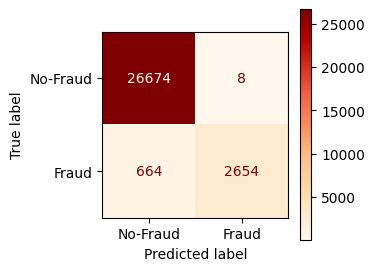

In [300]:
# Visualise the confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(3,3))
display_labels = ['No-Fraud','Fraud']
ConfusionMatrixDisplay.from_predictions(Y_test, rf_pred, display_labels=display_labels, ax=ax, cmap='OrRd')

In [301]:
# Compute the main metrics
rf_recall = recall_score(Y_test, rf_pred)
rf_precision = precision_score(Y_test, rf_pred)
rf_f1 = f1_score(Y_test, rf_pred)
rf_accuracy = accuracy_score(Y_test, rf_pred)

rf_scores = pd.DataFrame(data=[(rf_recall, rf_precision, rf_f1, rf_accuracy)],
                         columns=['Recall','Precision','F1 Score', 'Accuracy'],
                         index=['Random Forest'])

rf_scores.head()

,Recall,Precision,F1 Score,Accuracy
Random Forest,0.799879,0.996995,0.887625,0.9776


Data upscaling

In [302]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print(X_scaled.describe())




       TransactionID        Amount    MerchantID  TransactionType  \
count   1.000000e+05  1.000000e+05  1.000000e+05     1.000000e+05   
mean   -3.637979e-17 -1.006484e-16  6.412648e-17     6.963319e-17   
std     1.000005e+00  1.000005e+00  1.000005e+00     1.000005e+00   
min    -1.732033e+00 -1.730468e+00 -1.734157e+00    -1.219361e+00   
25%    -8.660167e-01 -8.660081e-01 -8.647856e-01    -1.219361e+00   
50%     0.000000e+00 -4.108860e-04  4.585604e-03    -5.077507e-02   
75%     8.660167e-01  8.641793e-01  8.704932e-01     1.117811e+00   
max     1.732033e+00  1.735068e+00  1.726010e+00     2.286398e+00   

           Location  
count  1.000000e+05  
mean   9.691803e-17  
std    1.000005e+00  
min   -1.511488e+00  
25%   -8.226806e-01  
50%   -1.338732e-01  
75%    8.993379e-01  
max    1.588145e+00  


In [303]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)

In [304]:
report = classification_report(y_test, y_pred)
print("Classification Report")
print(report)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('accuracy:%0.4f'%acc,'\tprecision:%0.4f'%prec,'\trecall:%0.4f'%rec,'\tF1-score:%0.4f'%f1)

Classification Report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     17757
           1       0.90      0.18      0.30      2243

    accuracy                           0.91     20000
   macro avg       0.90      0.59      0.62     20000
weighted avg       0.90      0.91      0.88     20000

accuracy:0.9054 	precision:0.9000 	recall:0.1765 	F1-score:0.2952


OverSampling

In [305]:
#OverSampling
from imblearn.over_sampling import SMOTE
# Apply SMOTE
smote = SMOTE()
X_resample, y_resample = smote.fit_resample(X, y.values.ravel())

In [306]:
y_resample

array([1, 1, 1, ..., 1, 1, 1])

In [307]:
print('Number of total transactions before SMOTE upsampling: ', len(Y), '...after SMOTE upsampling: ', len(y_resample))
print('Number of fraudulent transactions before SMOTE upsampling: ', len(Y[df['IsFraud']==1]),
      '...after SMOTE upsampling: ', np.sum(y_resample[y_resample==1]))
print('non-fraud transactions - 50% = 88939')
print('fraud transactions - 50% = 88939')

Number of total transactions before SMOTE upsampling:  100000 ...after SMOTE upsampling:  177878
Number of fraudulent transactions before SMOTE upsampling:  11061 ...after SMOTE upsampling:  88939
non-fraud transactions - 50% = 88939
fraud transactions - 50% = 88939


In [308]:
y_resample = pd.DataFrame(y_resample)
X_resample = pd.DataFrame(X_resample)

In [309]:
X_train, X_test, y_train, y_test = train_test_split(X_resample,y_resample,test_size=0.3)

In [315]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train.to_numpy().ravel())

LogisticRegression(max_iter=1000)

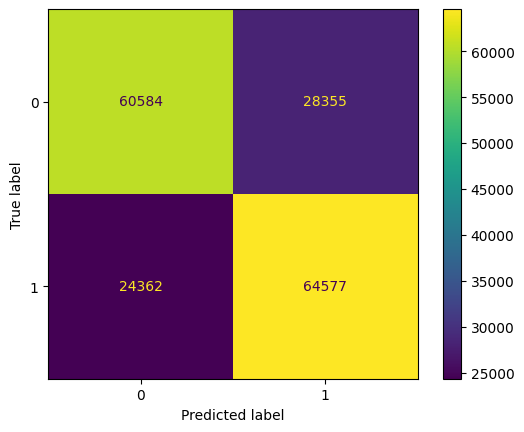

In [316]:
predictions = model.predict(X_resample)
cm = ConfusionMatrixDisplay(confusion_matrix(y_resample, predictions)).plot()

In [317]:
report = classification_report(y_resample, predictions)
print("Classification Report")
print(report)
acc = accuracy_score(y_resample, predictions)
prec = precision_score(y_resample, predictions)
rec = recall_score(y_resample, predictions)
f1 = f1_score(y_resample, predictions)
print('accuracy:%0.4f'%acc,'\tprecision:%0.4f'%prec,'\trecall:%0.4f'%rec,'\tF1-score:%0.4f'%f1)

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.68      0.70     88939
           1       0.69      0.73      0.71     88939

    accuracy                           0.70    177878
   macro avg       0.70      0.70      0.70    177878
weighted avg       0.70      0.70      0.70    177878

accuracy:0.7036 	precision:0.6949 	recall:0.7261 	F1-score:0.7101
